# Análisis de datasets de noticias

In [1]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
from glob import glob
from tqdm import tqdm
import re
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Category10
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Comparamos los articulos de las distintas categorias

In [2]:
path_, filename_, category_, article_or_summary_,content_ = [],[],[],[],[]
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        path = os.path.join(dirname, filename).replace("\\","/")
        f = open(os.path.join(dirname, filename),"r")
        try:
            article = str(f.read())
            article = article.replace("\\n",'')
            # Remove all excepth the alphabets
            article = re.sub("[^a-zA-Z0-9]",' ', article)
            content_.append(article)
            path_.append(path)
            filename_.append(filename)
            category_.append(path.split("/")[-2])
            article_or_summary_.append(path.split("/")[-3])
        except:
            print("ERROR ABRIENDO EL FICHERO")
        

ERROR ABRIENDO EL FICHERO


In [3]:
df = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_,"content":content_}, columns=["path", "filename", "category", "article_or_summary","content"])
df

,path,filename,category,article_or_summary,content
0,data/Articles/business/001.txt,001.txt,business,Articles,Ad sales boost Time Warner profit Quarterly p...
1,data/Articles/business/002.txt,002.txt,business,Articles,Dollar gains on Greenspan speech The dollar h...
2,data/Articles/business/003.txt,003.txt,business,Articles,Yukos unit buyer faces loan claim The owners ...
3,data/Articles/business/004.txt,004.txt,business,Articles,High fuel prices hit BA s profits British Air...
4,data/Articles/business/005.txt,005.txt,business,Articles,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...,...
4444,data/Summaries/tech/397.txt,397.txt,tech,Summaries,BT is introducing two initiatives to help beat...
4445,data/Summaries/tech/398.txt,398.txt,tech,Summaries,A third of them read unsolicited junk e mail a...
4446,data/Summaries/tech/399.txt,399.txt,tech,Summaries,This goes to the heart of the European project...
4447,data/Summaries/tech/400.txt,400.txt,tech,Summaries,Amit Yoran was director of the National Cyber ...


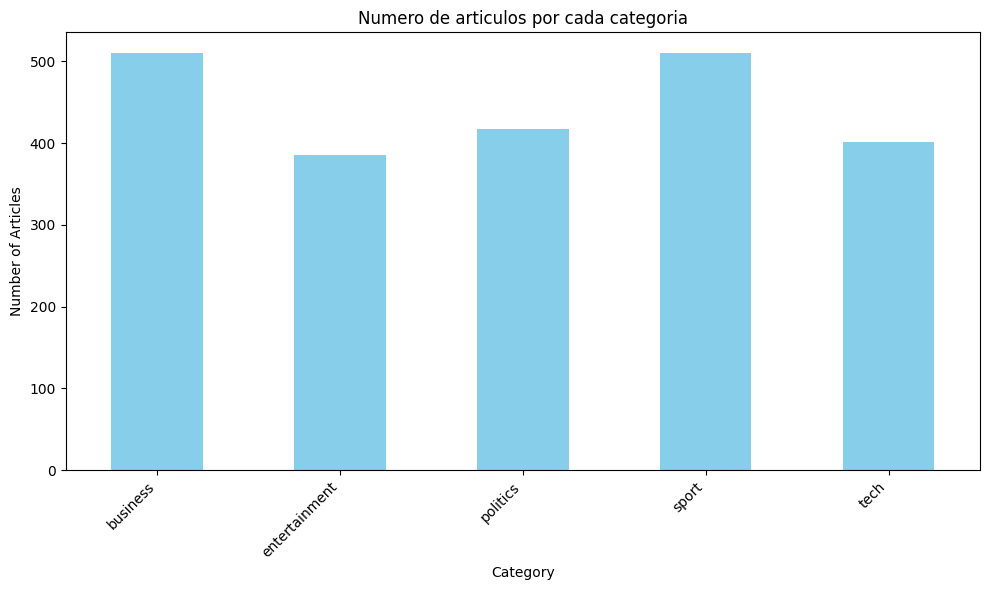

In [4]:
category_counts = df[df["article_or_summary"]=="Articles"].groupby('category').size()

# Plot a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Numero de articulos por cada categoria')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
categories = ["business","entertainment","politics","sport","tech"]
articles_cat = {}
for category in categories:
    abs_filepaths = glob(f"data/Articles/{category}/*.txt")
    # Read it and store it in a list
    news_articles = ""

    for abs_filepath in tqdm(abs_filepaths, colour='yellow'):
        try:
            # Open the file
            f = open(abs_filepath,"r")
            category_.append(path.split("/")[-2])
            # Read the contents of the file
            article = str(f.read())
            article = article.replace("\\n",'')
            # Remove all excepth the alphabets
            article = re.sub("[^a-zA-Z0-9]",' ', article)
            
            # Lower all the aplhabets
            article = article.lower()
            news_articles = " ".join([news_articles, article])
        except:
            print("ERROR ABRIENDO EL FICHERO")
    words = news_articles.split()
    articles_cat[category] = (news_articles,int(len(words)/len(abs_filepaths)))

100%|██████████| 511/511 [00:00<00:00, 2723.65it/s]


ERROR ABRIENDO EL FICHERO


100%|██████████| 401/401 [00:00<00:00, 1704.62it/s]


In [6]:
avg_sizes = ([value[1] for value in articles_cat.values()])
sc_avg_sizes = ([value[1]/4 for value in articles_cat.values()])
# Create the plot
p = figure(x_range=categories, height=350, title="Número de palabras medio de las noticias por categoria",
           toolbar_location=None, tools="")

# Add circles to the plot
p.circle(x=categories, y=0, size=sc_avg_sizes, color=Category10[5], alpha=0.6)

# Add category labels
p.text(x=categories, y=0, text_align='center', text_baseline='middle',
       text_font_size='10pt')

p.text(x=categories, y=0, text=avg_sizes, text_align='center', text_baseline='middle',
       text_font_size='8pt', text_color='black')

# Remove gridlines
p.grid.grid_line_color = None
p.x_range.range_padding = 0.2
# Set axis labels
p.xaxis.axis_label = "Categories"
p.yaxis.visible = False

output_notebook()
show(p)

Loading BokehJS ...

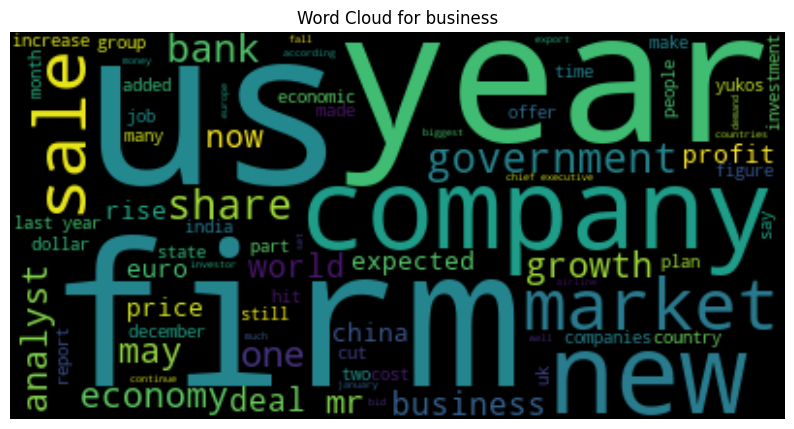

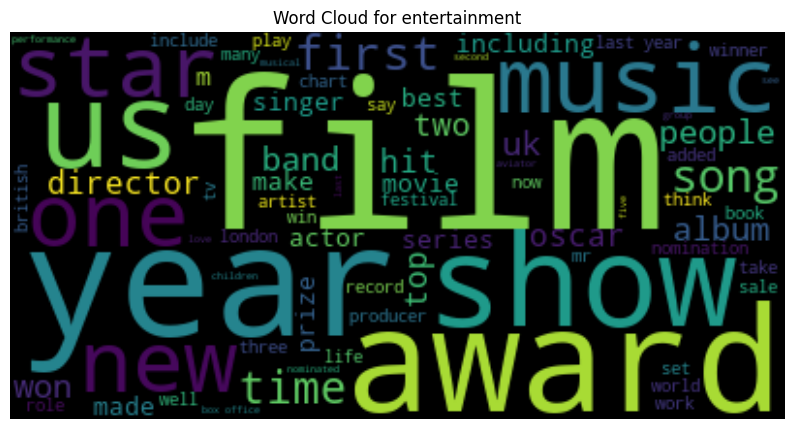

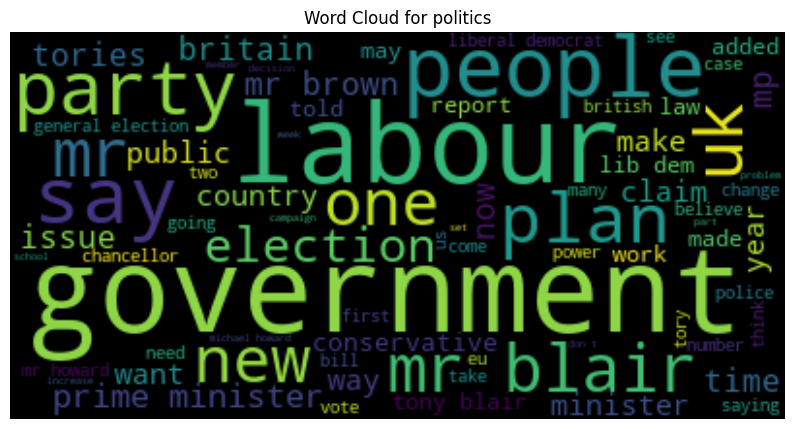

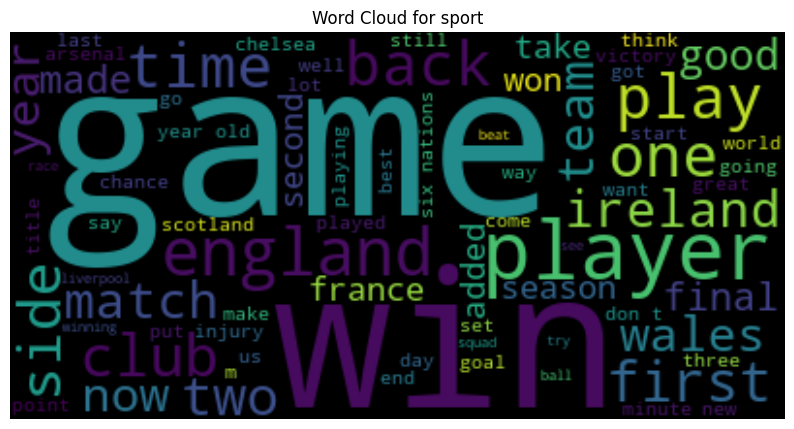

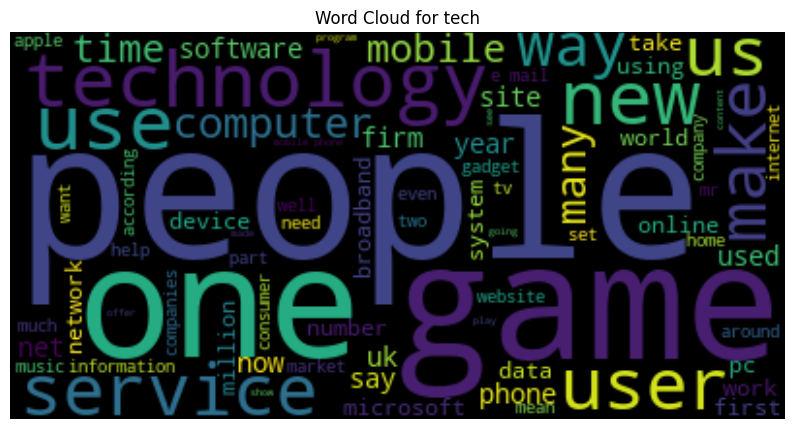

In [7]:
stop_words = ["will", "said", "s","u"] + list(STOPWORDS)
for category, (article, _) in articles_cat.items():
    # Generate word cloud for the article
    wordcloud = WordCloud(stopwords=stop_words,max_words = 75).generate(article)
    
    # Display the generated image
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category}")
    plt.axis("off")
    plt.show()

## 2. Buscar articulos por palabras clave usando TF-IDF

In [8]:
# Calculamos primero la matriz de TF-IDF
text_content = df['content']
vector = TfidfVectorizer(max_df=0.3,         # drop words that occur in more than X percent of documents
                             #min_df=8,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

In [9]:
def search(tfidf_matrix,model,request, top_n = 5):
    request_transform = model.transform([request])
    similarity = np.dot(request_transform,np.transpose(tfidf_matrix))
    x = np.array(similarity.toarray()[0])
    indices=np.argsort(x)[-5:][::-1]
    return indices

In [16]:
pd.set_option('display.max_colwidth', None)
request = 'recession euro bank'
result = search(tfidf,vector, request, top_n = 5)
df.loc[result][["category","content"]]

,category,content
349,business,Dollar hits new low versus euro The US dollar has continued its record breaking slide and has tumbled to a new low against the euro Investors are betting that the European Central Bank ECB will not do anything to weaken the euro while the US is thought to favour a declining dollar The US is struggling with a ballooning trade deficit and analysts said one of the easiest ways to fund it was by allowing a depreciation of the dollar They have predicted that the dollar is likely to fall even further The US currency was trading at 1 364 per euro at 1800 GMT on Monday This compares with 1 354 to the euro in late trading in New York on Friday which was then a record low The dollar has weakened sharply since September when it traded about 1 20 against the euro It has lost 7 this year while against the Japanese yen it is down 3 2 Traders said that thin trading levels had amplified Monday s move It s not going to take much to push the dollar one way or the other said Grant Wilson of Mellon Bank Liquidity a measure of the number of parties willing to trade in the market was about half that of a normal working day traders said
2599,business,Against the yen the dollar was trading down at 103 05 The US dollar has hit a new record low against the euro and analysts predict that more declines are likely in 2005 The dollar slid to a record 1 3666 versus the euro on Thursday before bouncing back to 1 3636 Disappointing economic reports dented the currency which had been rallying after European policy makers said they were worried about the euro s strength The yen meanwhile dropped to 141 60 per euro in afternoon trading Mr Berlusconi said the euro s strength was absolutely worrying for Italian exports Earlier on Thursday the Japanese yen touched its lowest versus the euro on concerns about economic growth in Asia
2573,business,The US dollar has continued its record breaking slide and has tumbled to a new low against the euro The US is struggling with a ballooning trade deficit and analysts said one of the easiest ways to fund it was by allowing a depreciation of the dollar The dollar has weakened sharply since September when it traded about 1 20 against the euro The US currency was trading at 1 364 per euro at 1800 GMT on Monday Investors are betting that the European Central Bank ECB will not do anything to weaken the euro while the US is thought to favour a declining dollar
2229,business,On an annual basis the data suggests annual growth of just 0 2 suggesting a much more hesitant recovery than had previously been thought A common technical definition of a recession is two successive quarters of negative growth Revised figures indicated growth of just 0 1 and a similar sized contraction in the previous quarter Japan s economy teetered on the brink of a technical recession in the three months to September figures show
2267,business,Japan s economy grew 2 6 overall last year fuelled by a strong performance in the first few months and is forecast to see growth of 2 1 in 2005 Japan s economy has seen stretches of moderate growth over the past decade but has periodically slipped back into recession A recession is commonly defined as two consecutive quarters of negative growth although the Japanese government takes other factors into account when judging the status of its economy The Japanese economy has officially gone back into recession for the fourth time in a decade Gross domestic product fell by 0 1 in the last three months of 2004 The Tokyo stock market fell after the figures were announced but rose again on a widespread perception that the economy will recover later this year The economy has some soft patches but if you look at the bigger picture it is in a recovery stage said Economic and Fiscal Policy Minister Heizo Takenaka The fall reflects weak exports and a slowdown in consumer spending and follows similar falls in GDP in the two previous quarters
